In [1]:
import cupy as cp
import cuml
import sys
sys.path.append('/home/jhovan/Documents/CustomImplementations/gentleboost')
from gentleboost import GentleBoost


In [4]:
from cuml.datasets import make_classification

# Create dataset
X, y = make_classification(
    n_samples=10000,
    n_features=20,
    n_classes=2,
    n_clusters_per_class=3,
    n_informative=15,
    random_state=42,
    class_sep=1.0,  # Increase class separation
    weights=[0.7, 0.3]
)
X = cp.array(X)
y = cp.array(y)
y_shifted = 2 * y - 1
# scale X
X_scaled = X / cp.linalg.norm(X, axis=0)


Iteration 0, Training Error: 0.3011
Iteration 10, Training Error: 0.2158
Iteration 20, Training Error: 0.1729
Iteration 30, Training Error: 0.1559
Iteration 40, Training Error: 0.1451
Iteration 50, Training Error: 0.1394
Iteration 60, Training Error: 0.1328
Iteration 70, Training Error: 0.1265
Iteration 80, Training Error: 0.1221
Iteration 90, Training Error: 0.1180

Parameters: n_estimators=100
Training Accuracy: 0.8851
Final Training Error: 0.1147
Iteration 0, Training Error: 0.3011
Iteration 10, Training Error: 0.2158
Iteration 20, Training Error: 0.1729
Iteration 30, Training Error: 0.1559
Iteration 40, Training Error: 0.1451
Iteration 50, Training Error: 0.1394
Iteration 60, Training Error: 0.1328
Iteration 70, Training Error: 0.1265
Iteration 80, Training Error: 0.1221
Iteration 90, Training Error: 0.1180
Iteration 100, Training Error: 0.1154
Iteration 110, Training Error: 0.1131
Iteration 120, Training Error: 0.1112
Iteration 130, Training Error: 0.1095
Iteration 140, Training E

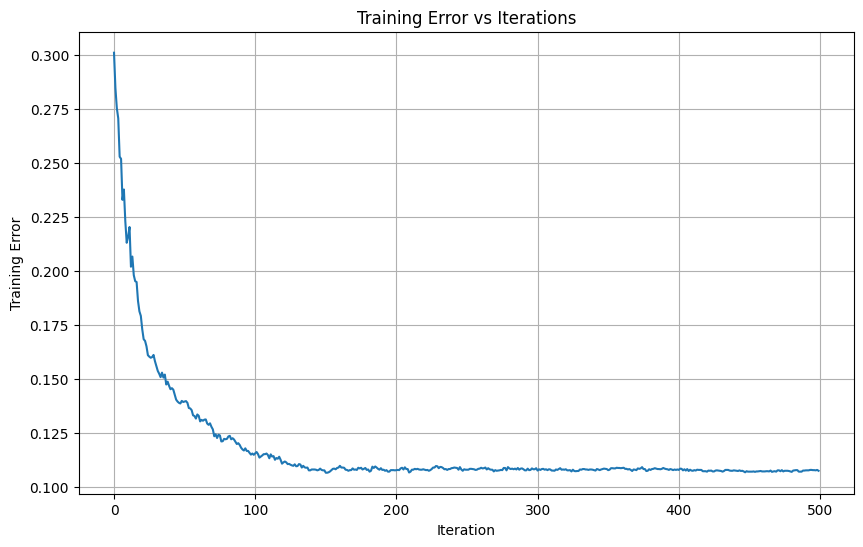

In [11]:
# Try different numbers of estimators
n_estimators_list = [100, 200, 300, 400, 500]

best_accuracy = 0
best_params = {}

for n_est in n_estimators_list:
    gb_classifier = GentleBoost(n_estimators=n_est)
    gb_classifier.fit(X_scaled, y_shifted)
    y_pred = gb_classifier.predict(X_scaled)
    accuracy = cp.mean(y_shifted == y_pred)
    
    print(f"\nParameters: n_estimators={n_est}")
    print(f"Training Accuracy: {accuracy:.4f}")
    print(f"Final Training Error: {gb_classifier.training_errors_[-1]:.4f}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'n_estimators': n_est}

print(f"\nBest parameters: {best_params}")
print(f"Best accuracy: {best_accuracy:.4f}")

# Optional: Plot training error curve for best model
import matplotlib.pyplot as plt

best_gb = GentleBoost(n_estimators=best_params['n_estimators'])
best_gb.fit(X_scaled, y_shifted)

plt.figure(figsize=(10, 6))
plt.plot(best_gb.training_errors_)
plt.title('Training Error vs Iterations')
plt.xlabel('Iteration')
plt.ylabel('Training Error')
plt.grid(True)
plt.show()

In [5]:
# Try DummyClassifier with most_frequent strategy
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X.get(), y.get())
y_pred = dummy_clf.predict(X.get())
accuracy = cp.mean(y.get() == y_pred)
print(f"Dummy Classifier (most_frequent) Accuracy: {accuracy:.4f}")


Dummy Classifier (most_frequent) Accuracy: 0.6989


In [7]:
from cuml.linear_model import LogisticRegression

lr_classifier = LogisticRegression()
lr_classifier.fit(X, y)
y_pred = lr_classifier.predict(X)
accuracy = cp.mean(y == y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.4f}")

Logistic Regression Accuracy: 0.9628


In [10]:
# comparing to KNN classifier
from cuml.neighbors import KNeighborsClassifier

# try KNN with differnt number of neighbors
k_values = [3, 5, 7, 9]
for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X, y)
    y_pred = knn_classifier.predict(X)
    accuracy = cp.mean(y == y_pred)
    print(f"KNN with {k} neighbors Accuracy: {accuracy:.4f}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'n_neighbors': k}

print(f"\nBest parameters: {best_params}")
print(f"Best accuracy: {best_accuracy:.4f}")

KNN with 3 neighbors Accuracy: 0.9832
KNN with 5 neighbors Accuracy: 0.9795
KNN with 7 neighbors Accuracy: 0.9782
KNN with 9 neighbors Accuracy: 0.9759

Best parameters: {'n_neighbors': 3}
Best accuracy: 0.9832
